# XGBoost tuning

Будем работать с данными - http://datahack.analyticsvidhya.com/contest/data-hackathon-3x.
Мы решаем задачу классификации на два класса. Сразу будем работать с обработанными и уменьшенными данными (для ускорения процесса обучения). Процесс обработки данных и полный и подробный туториал для данной задачи приведён здесь: https://github.com/aarshayj/Analytics_Vidhya/blob/master/Articles/Parameter_Tuning_XGBoost_with_Example. 

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import model_selection, metrics
from sklearn.model_selection import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

# Загружаем данные

Вы можете работать с train_medium/test_medium, если готовы немного подождать при обучении xgboost. Если вы хотите быстрых результатов, то работайте с файлами train_small/test_small.

In [3]:
# X_train = pd.read_csv('train_medium.csv')
# X_test = pd.read_csv('test_medium.csv')
X_train = pd.read_csv('train_small.csv')
X_test = pd.read_csv('test_small.csv')
len(X_train), len(X_test)

(24365, 10443)

In [4]:
target='Disbursed'
IDcol = 'ID'

In [5]:
X_train['Disbursed'].value_counts(), len(X_train)

(0.0    23999
 1.0      366
 Name: Disbursed, dtype: int64, 24365)

## Создадим функцию для моделирования и кросс-валидации

Эта функция делает следующее:
1. обучает модель
2. вычисляет accuracy на тренировочной выборке
3. вычисляет AUC на тренировочной выборке
4. вычисляет AUC на тестовой выборке
5. обновляет n_estimators с помощью встроенной в пакет xgboost функции cv
6. строит диаграмму Feature Importance 

In [6]:
def modelfit(alg, dtrain, dtest, predictors, useTrainCV=True, cv_folds=5, \
             early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
    #Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    print('AUC Score (Test): %f' % metrics.roc_auc_score(dtest['Disbursed'], dtest['predprob']))
                
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

## Начинаем последовательный подбор параметров при большом learning_rate

In [7]:
X_train.head()

,Unnamed: 0,Existing_EMI,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,Interest_Rate_Missing,...,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2,Disbursed
0,8161,0.0,250000.0,5.0,23200,2,3,28,1,1,...,0,0,0,0,0,1,0,1,0,0.0
1,77530,0.0,0.0,0.0,25000,0,0,33,1,1,...,0,0,0,1,0,1,1,0,0,0.0
2,80633,0.0,0.0,0.0,95000,3,7,39,1,1,...,0,0,0,1,0,1,1,0,0,0.0
3,45059,0.0,0.0,0.0,29880,5,3,28,0,0,...,0,0,0,0,0,1,0,1,0,0.0
4,54857,4500.0,100000.0,3.0,30000,5,10,26,0,0,...,0,0,0,1,0,1,1,0,0,0.0



Model Report
Accuracy : 0.985
AUC Score (Train): 0.894509
AUC Score (Test): 0.829832


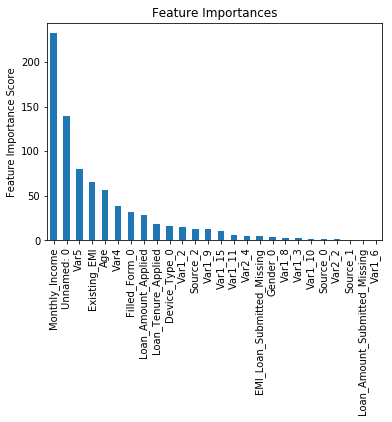

In [8]:
predictors = [x for x in X_train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate=0.1,
        n_estimators=150,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, X_train, X_test, predictors)

Перебираем max_depth и min_child_weight по сетке.

In [9]:
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=150,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_train[predictors],X_train[target])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [10]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 3}, 0.8258301957175644)

Уточняем предсказание

In [ ]:
param_test2 = {
    'max_depth':[2,3,4],
    'min_child_weight':[2,3,4]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=150, 
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train[predictors],X_train[target])

In [ ]:
gsearch2.best_params_, gsearch2.best_score_

Зафиксируем найденный max_depth и подберем min_child_weight

In [ ]:
param_test2b = {
    'min_child_weight':[5,6,7]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=150, max_depth=4,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(X_train[predictors],X_train[target])

In [ ]:
gsearch2b.best_params_, gsearch2b.best_score_

Мы подобрали max_depth и min_child_weight - дальше будем использовать подобранные значения параметров. Подберите по сетке параметр gamma на отрезке от 0 до 1.

In [ ]:
param_test3 = {
    'gamma':#your code here
}
gsearch3b = #your code here
gsearch3b.fit(X_train[predictors],X_train[target])

In [ ]:
gsearch3b.best_params_, gsearch3b.best_score_

Установите в качестве параметров алгоритма подобранные max_depth, min_child_weight и gamma и посмотрите как изменилось качество.

In [ ]:
predictors = [x for x in X_train.columns if x not in [target, IDcol]]
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=150,
        max_depth=4,
        min_child_weight=...,
        gamma = ...,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb2, X_train, X_test, predictors)

Подберите по сетке параметры subsample и colsample_bytree. Используйте значения этих параметров: [0.6,0.7,0.8,0.9,1.]

In [ ]:
#Your code here

Уточните значения subsample и colsample_bytree. Например, если оптимальный subsample на предыдущем шаге равен 0.6, то теперь перебирайте subsample в диапазоне [0.55,0.6,0.65,0.7]. Аналогично с colsample_bytree.

In [ ]:
#Your code here

Подберите параметр регуляризации reg_alpha. Попробуйте [1e-5, 1e-2, 0.1, 1, 100]

In [ ]:
#Your code here

Уточните параметр reg_alpha, исходя из найденного оптимума.

In [ ]:
#Your code here

Запустите обучение и предсказание на найденных параметрах и посмотрите на качество.

In [ ]:
xgb3 = XGBClassifier(
        learning_rate=0.1,
        n_estimators=150,
        max_depth=...,
        min_child_weight=...,
        gamma=...,
        subsample=...,
        colsample_bytree=...,
        reg_alpha=...,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb3, X_train, X_test, predictors)

Уменьшите learning_rate до 0.01 и пропорционально увеличьте число деревьев. Все подобранные параметры остаются такими же. Обучите модель и сделайте предсказание. Посмотрите на качество.

In [ ]:
#Your code here
xgb3 = XGBClassifier(
        learning_rate=0.01,
        n_estimators=1500,
        max_depth=...,
        min_child_weight=...,
        gamma=...,
        subsample=...,
        colsample_bytree=...,
        reg_alpha=...,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb3, X_train, X_test, predictors)